In [1]:
import ingestor, modeller, fitter, viewer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k", "m"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)
reload(viewer)

<module 'viewer' from '/media/dwu402/Data/self-harm/viewer.py'>

In [5]:
context = ingestor.Context("runs/passivefull4.3.run")

In [6]:
solver = fitter.Fitter(context)

In [23]:
#solver.read('out/smol-case-2-force-inner-positive.out')
#solver.write('out/smol-case-43.out')

In [8]:
rhos = np.logspace(-6, 8, num=57)
for rhoi in rhos:
    solver.solve(rhoi, propagate=True)

# Validation

In [9]:
view = viewer.Plotter(context=context, fitter=solver)

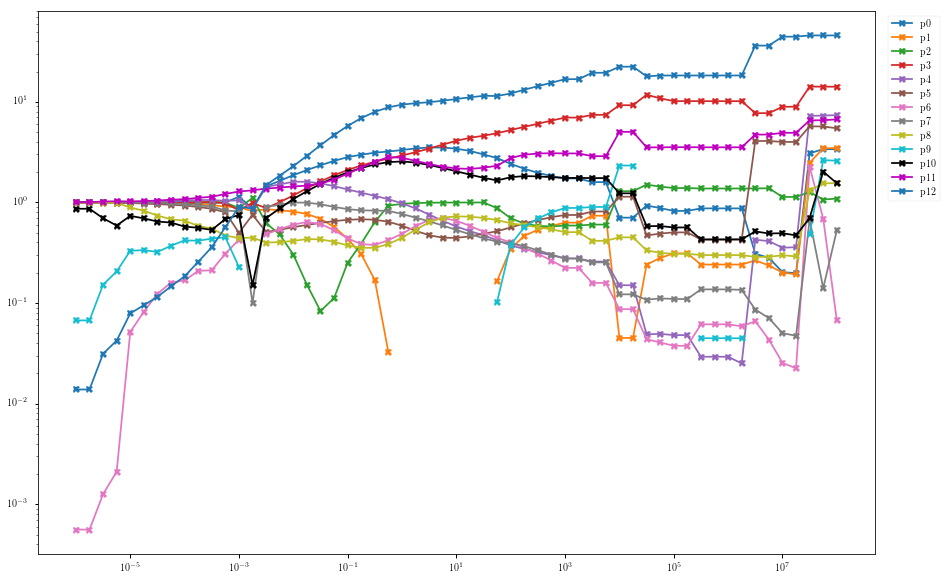

In [10]:
view.show_parameter_values()

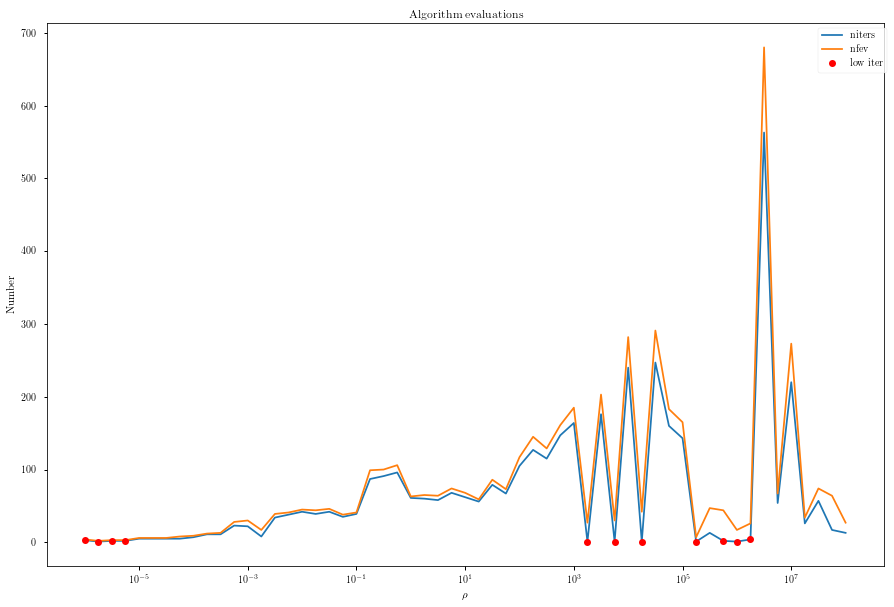

In [11]:
view.show_iterations()

5.623413251903491
 is the closest


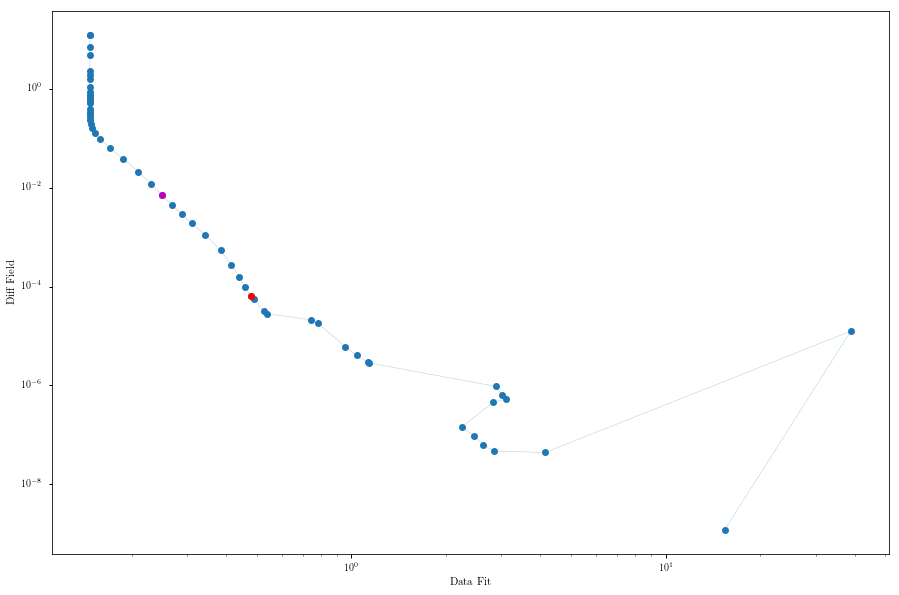

In [12]:
good_rho=view.draw_lcurve(target_rho=1e3, optimal=True)

par r=1.9701861648762962
par a=0.5364796227869063
par b=0.5841636527011124
par k=6.059877469791314
par p=0.32063616069098316
par m=0.6685047815217431
par s=0.30889059602782093
par c=0.33447410869605426
par d=0.5680940071092588
par f=0.6933732867150098
par g=1.8151684548716782
par j=3.0639759276615144
par l=14.307464892501256


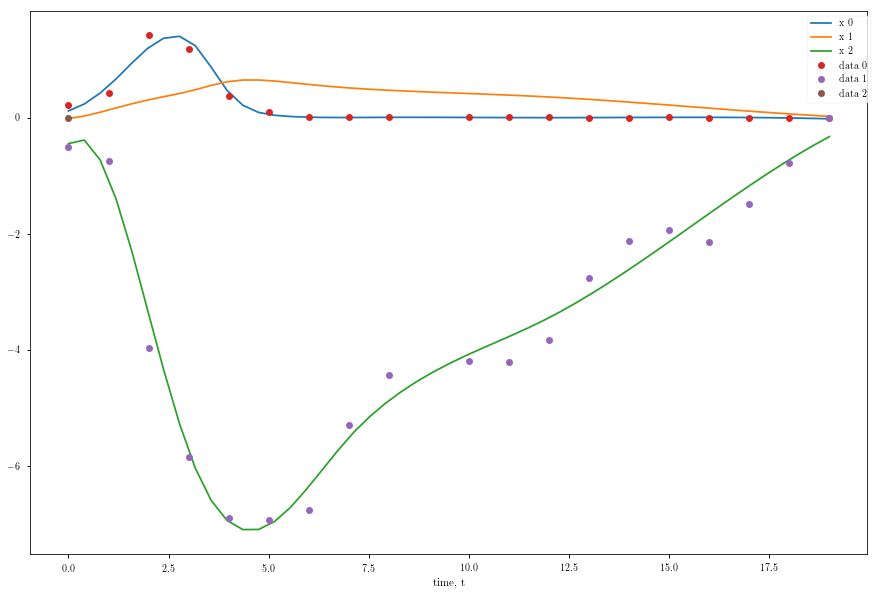

In [13]:
view.print_solution(316.22776601683796, labels='rabkpmscdfgjl')
view.draw_solution(316.22776601683796)

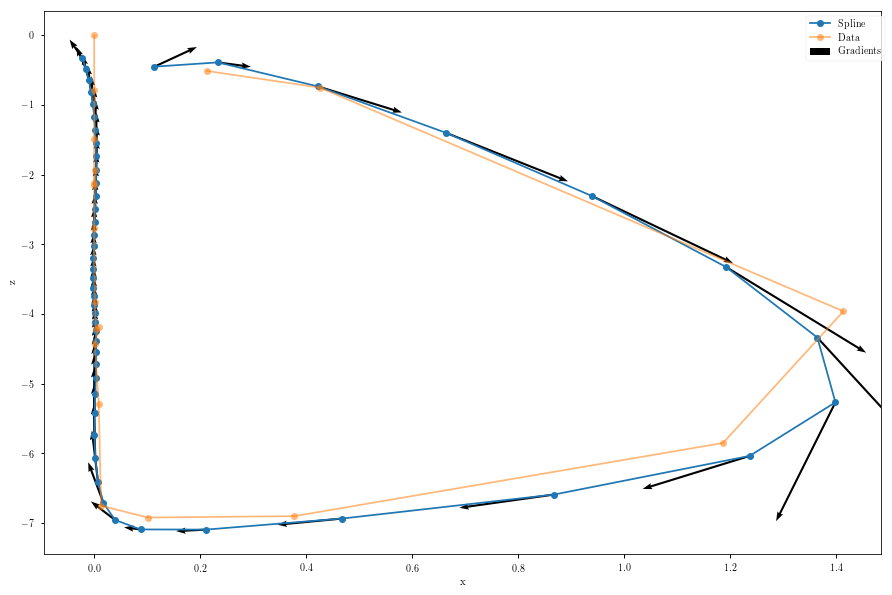

In [14]:
view.draw_solution(target_rho=316.22776601683796, plane=[0,2], datakeys=['x','z'])

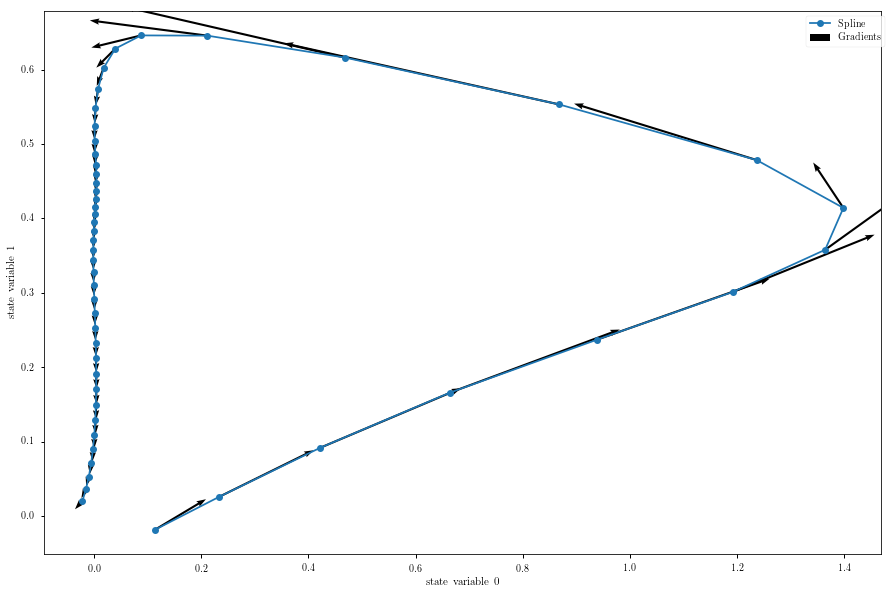

In [15]:
view.draw_solution(target_rho=316.22776601683796, plane=[0,1])

[120.87562984918256, 49.17504161047874, 34.789261644463245, 18.73318079716578, 58.50314329594067, 14.648412092470421, 194.8148893436471, 145.86640991659192, 91.30467699939243, 2752.017720283694, 10609.735681420447, 120.87562984918252, 91.30467699939241]


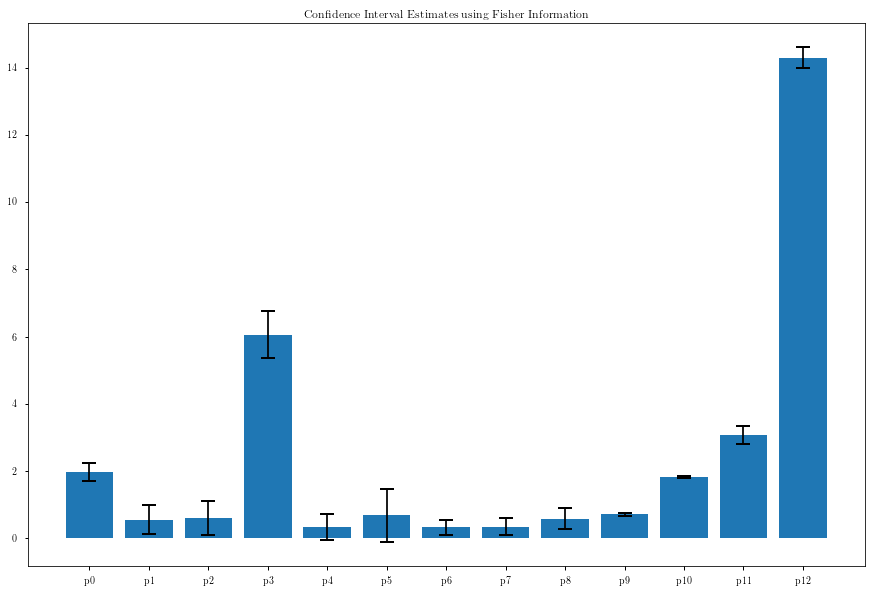

In [16]:
view.draw_confidence(target_rho=316.22776601683796, verbose=True)

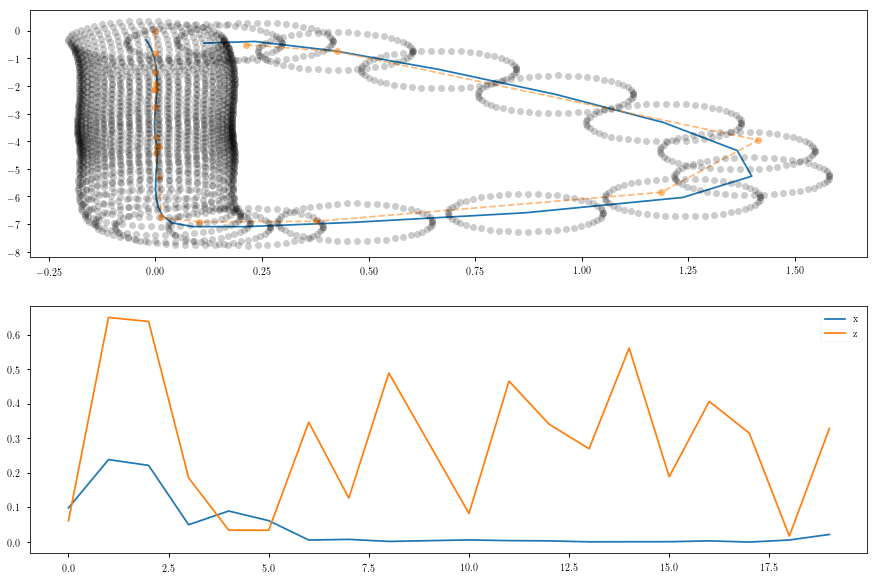

In [17]:
view.draw_error(target_rho=316.22776601683796, indexkeys={0:'x', 2:'z'})

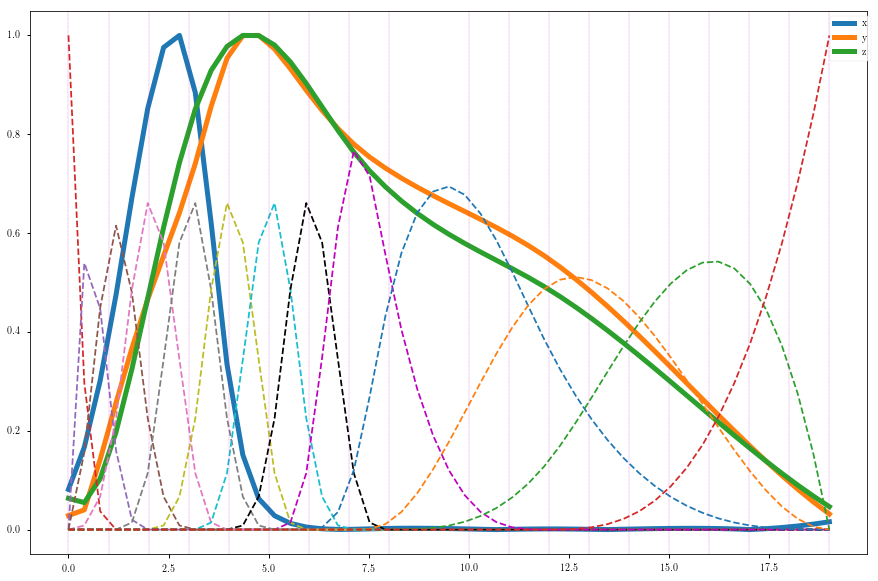

In [18]:
view.draw_basis(target_rho=316.22776601683796, labels='xyz')

/media/dwu402/Data/self-harm/viewer.py:283: RuntimeWarning: invalid value encountered in sqrt
  intervals = 3*np.sqrt(1/np.array(self.calculate_confidence(rho, problem)))
/media/dwu402/Data/self-harm/viewer.py:283: RuntimeWarning: divide by zero encountered in true_divide
  intervals = 3*np.sqrt(1/np.array(self.calculate_confidence(rho, problem)))
/media/dwu402/Data/self-harm/viewer.py:287: RuntimeWarning: divide by zero encountered in true_divide
  error = intervals/self.p_of(rho, problem)


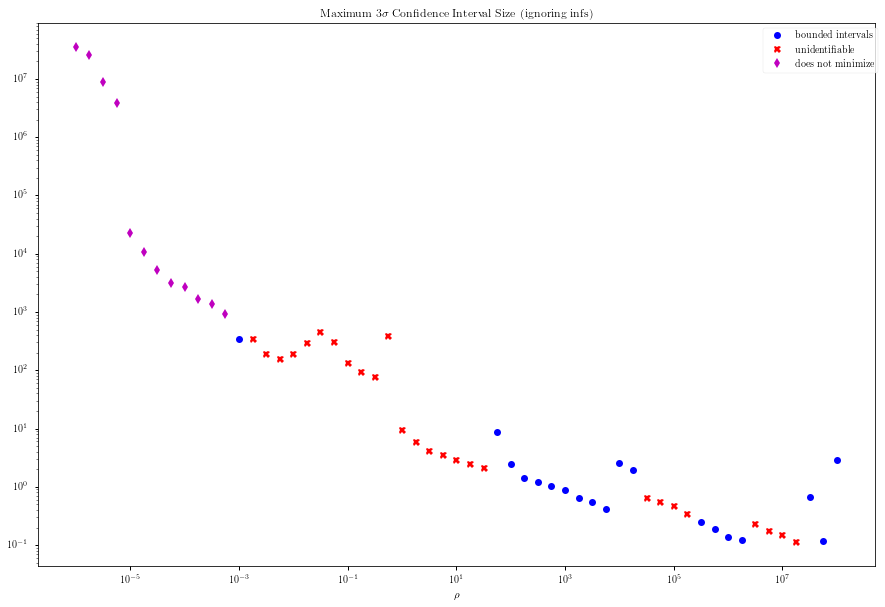

In [19]:
view.validate_on_confidence(method="relative")


## Analysis

In [20]:
# %%script false

# r,a,b,k,p,m,s,c,d,f,g,j,l = solver.solutions[str(target_rho)][0].x
# characteristic1 = np.roots([-d, s, 0, -d*c*c*c, 0])
# temp_alpha = (s*r*r*r)/(c*c*c*k*k*k+r*r*r) - d*r/k
# characteristic2 = np.roots([temp_alpha, p, m*m*temp_alpha])

# # these are the values of gamma and xi
# print(characteristic1)
# print(characteristic2)

# eq_values1 = l*characteristic1/(f*characteristic1 - g)
# eq_values2 = (j*k*characteristic2 + l*r)/(f*r-g*k)

# print(eq_values1)
# print(eq_values2)

# rk = r/k

# def is_stable(point):
#     x,y,z = point
#     G = f*y-g
#     A = r-k*y
#     B = -k*x
#     C = p/(m**2+x**2) - (2*p*x**2)/(m**2+x**2)**2
#     D = (3*s*y**2)/(c**3 + y**3) - d - (3*s*y**5)/(c**3 + y**3)**2
#     character = (G<0, (A+D)<0 , A*D-B*C>0)
#     if all(character):
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "z-xy-focus"
#         return "z-xy"
#     elif character[0:3:2] == (True, False):
#         return "z-saddle"
#     elif character == (False, True, True):
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "unstable-xy-focus"
#         return "unstable-xy"
#     elif character[0]:
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "z-unstable-focus"
#         return "z-unstable"
#     else:
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "unstable-unstable-focus"
#         return "unstable-unstable"
    
# stabilities1 = [is_stable([0, ch, eq]) for ch, eq in zip(characteristic1, eq_values1)]
# stabilities2 = [is_stable([ch, rk, eq]) for ch, eq in zip(characteristic2, eq_values2)]

# print(stabilities1)
# print(stabilities2)

# plt.plot([0]*len(eq_values1[np.isreal(eq_values1)]), eq_values1[np.isreal(eq_values1)], 'ro')
# plt.plot(characteristic2[np.isreal(eq_values2)], eq_values2[np.isreal(eq_values2)], 'ro')

# print(f*r/k-g)

## Smoothing Experiments

In [21]:
from scipy import interpolate

In [22]:
smooth_outer = interpolate.UnivariateSpline(np.log10(rhos), np.log10(datafit_values[:,1]), s=2)
souter =  np.array([10**x for x in smooth_outer(np.log10(rhos))])
plt.loglog(rhos, souter, rhos, datafit_values[:,1], 'o')
plt.gca().xaxis.grid(True)

NameError: name 'datafit_values' is not defined

In [ ]:
smooth_dfield = interpolate.UnivariateSpline(np.log10(rhos), np.log10(dfield_direct[:,1]), s=7)
sfield =  np.array([10**x for x in smooth_dfield(np.log10(rhos))])
plt.loglog(rhos, sfield, rhos, dfield_direct[:,1], 'o')
plt.gca().xaxis.grid(True)

In [ ]:
rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)
sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)
plottable_sx = 10**sx
plottable_sy = 10**sy

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(rhos_log_finer, sx)
ax2.plot(rhos_log_finer, sy)
ax1.set_ylabel("Data Fit")
ax2.set_ylabel("Gradient Field Discrepancy")

In [ ]:
plt.loglog(plottable_sx, plottable_sy, '*--', datafit_values[:,1], dfield_direct[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Fit to Data $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

plt.loglog(plottable_sx[np.argmin(np.abs(rhos_log_finer - 2.5))],
           plottable_sy[np.argmin(np.abs(rhos_log_finer - 2.5))],
           'ro',
           datafit_values[np.argmin(np.abs(np.array(rhos) - 5)), 1],
           dfield_direct[np.argmin(np.abs(np.array(rhos) - 5)), 1], 
           'ko')

In [ ]:
# ? curvature
f_dx = smooth_outer.derivative(1)
f_dy = smooth_dfield.derivative(1)
f_dx2 = smooth_outer.derivative(2)
f_dy2 = smooth_dfield.derivative(2)

scurv_dx = f_dx(rhos_log_finer)
scurv_dy = f_dy(rhos_log_finer)
scurv_dx2 = f_dx2(rhos_log_finer)
scurv_dy2 = f_dy2(rhos_log_finer)

kappa_fine = scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2/(scurv_dx**2 + scurv_dy**2)**(3/2)

plt.semilogy(rhos_log_finer, kappa_fine, 'o-')
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

In [ ]:
# menger curvature
curvs = []

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.semilogy(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

In [ ]:
# implement the heuristic measurement
origin  = (0,0)
xy = np.array(list(zip(plottable_sx, plottable_sy)))
distances = [np.linalg.norm(xyi) for xyi in xy]
plt.plot(rhos_log_finer, [1/d for d in distances])

In [ ]:
# implement a GM heuristic
xy = np.array(list(zip(plottable_sx, plottable_sy)))
gmdistances = [np.sqrt(np.prod(xyi)) for xyi in xy]
plt.plot(rhos_log_finer, [1/g for g in gmdistances])

In [ ]:
tot_heur = 1/np.sum([gmdistances,distances], axis=0)
plt.plot(rhos_log_finer, tot_heur)

In [ ]:
observable_x = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[0]
observable_z = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[2]

x_err = np.abs(observable_x.T - np.array(context.datasets[0]['x'])).reshape(-1,)
z_err = np.abs(observable_z.T - np.array(context.datasets[0]['z'])).reshape(-1,)

t = np.array(context.datasets[0]['t'])

plt.plot(t, x_err, t, z_err)
print(f"{np.mean(x_err)} : {np.std(x_err)}")
print(f"{np.mean(z_err)} : {np.std(z_err)}")


In [ ]:
x0, y0 = xs_end[[0,2], :]
xscale = np.mean(x_err) + 1.96*np.std(x_err)
zscale = np.mean(z_err) + 1.96*np.std(z_err)
circle_x, circle_y = [x0 + xscale*np.cos(np.linspace(0, 2*np.pi, 50)), y0 + zscale*np.sin(np.linspace(0, 2*np.pi, 50))]

plt.plot(xs_end[0], xs_end[2])
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.plot(circle_x, circle_y, 'ko', alpha=0.2)
print('')


In [ ]:
## Use heuristic to estimate the "ideal" parameter
maximus = 10**rhos_log_finer[np.argmax(tot_heur)+1]
print(f"{maximus}\n is the spike")
closest_rho = rhos[np.argmin(np.abs(rhos-maximus))]
print(f"{closest_rho}\n is the closest")

# Utilities

In [ ]:
solver.solutions

In [ ]:
[str(rho) for rho in rhos]